In [ ]:
import sys,os,os.path
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/gluster/data/next/software/IC_satkill/")
#sys.path.append("/gluster/data/next/software/IC_sophronia/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import time

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs
from matplotlib.lines import Line2D


import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize


from tqdm import tqdm


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in tqdm(dst.groupby(['event', times])):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    print("Collecting hits from dataframe...")
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

def collect_min_max_bins(hits):
    '''
    returns all the min, max and mid values you'd need
    as well as the bins
    '''
    x_range = (hits.X.max()-hits.X.min())/2.
    y_range = (hits.Y.max()-hits.Y.min())/2.
    z_range = (hits.Z.max()-hits.Z.min())/2.
    mid_x   = (hits.X.max()+hits.X.min())/2.
    mid_y   = (hits.Y.max()+hits.Y.min())/2.
    mid_z   = (hits.Z.max()+hits.Z.min())/2.
    min_x = hits.X.min()
    min_y = hits.Y.min()
    min_z = hits.Z.min()

    max_x = hits.X.max()
    max_y = hits.Y.max()
    max_z = hits.Z.max()
    #print("X maximum and minimum")
    #print(max_x, min_x)
    #print("")

    #print("Y maximum and minimum")
    #print(max_y, min_y)
    #print("")

    #print("Z maximum and minimum")
    #print(max_z, min_z)

    xbins = int(hits.X.max()-hits.X.min())
    ybins = int(hits.Y.max()-hits.Y.min())
    zbins = int((hits.Z.max()-hits.Z.min())/2.)
    
    array = [x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins]
    
    return (array)



def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'").split("'")[0]


def count_tracks(hits_deco):
    
    
    
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.X
    ys = hits_deco.Y
    zs = hits_deco.Z
    es = hits_deco.E

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no

In [ ]:
# develop a function that can load in files, collect them like this, and add to a large dataframe.
def collect_signal_df(data_path, save_path = "", verbose = True):
    """
    Function that collects Tl208 signal events (identified with Xe ions created in 'conv' processes)
    """

     # collect all filenames
    try:
        file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.h5')]
    except:
        print("File path incorrect, please state the correct file path\n(but not any particular folder!)")

    # counter for creating first array
    i = 0


    for file in tqdm(file_names):
        file_path = data_path + file

        # load in data
        MC_df = pd.read_hdf(file_path, 'MC/particles')
        
        # set first dataframe
        if (i == 0):
            MC_signal_df = pd.DataFrame(columns = MC_df.columns.values)
            i = 1
        
        # collect conv slice and iterate over, scanning for Xe*** events
        conv_slice = MC_df[MC_df.creator_proc == 'conv']
        for e_id, df in conv_slice.groupby('event_id'):
            # check if conv selection has Xe isotope
            lst = df.particle_name.to_list()
            # truncate to only take 'Xe' as the input
            short_lst = []
            [short_lst.append(i[0:2]) for i in lst]
            if "Xe" in short_lst:
                if (verbose == True):
                    display(df)
                    print("Xe found in event {}".format(e_id))
                MC_signal_df = pd.concat([MC_signal_df, MC_df[MC_df.event_id == e_id]])

    # save if desired
    if save_path != "":
        MC_signal_df.to_hdf(str(save_path) + 'Tl_signal.h5', key = 'MC')

    # return dataframe    
    return MC_signal_df

def collect_soph_signal_df(data_path, event_ids, save_path = "", MC_check = True):
    '''

    Function that collects all sophronia signal events and stores them in a file

    This will produce a dataframe with all the 'RECO/Events' data
    for the relevant events.

    data_path -> path to the sophronia files
    event_ids -> array including all the event ids
    save_path -> path under which to save the data
    MC_check  -> check if the event ids are from MC, if so, they are doubled
    '''

    if MC_check == True:
        event_ids = event_ids * 2
         # collect all filenames
    try:
        file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.h5')]
    except:
        print("File path incorrect, please state the correct file path\n(but not any particular folder!)")

    # counter for creating first array
    i = 0


    #

    for file in tqdm(file_names):
        file_path = data_path + file

        # load in data
        soph_df = dstio.load_dst(file_path, 'RECO', 'Events')
        
        # set first dataframe
        if (i == 0):
            soph_signal_df = pd.DataFrame(columns = soph_df.columns.values)
            i = 1

        
        # collect unique event ids from file, and then find how many are signals 
        ids = np.array(soph_df.event.unique())
        available_evts = np.intersect1d(ids, event_ids)

        # collect the signal events from the files
        for i in available_evts:
            soph_signal_df = pd.concat([soph_signal_df, soph_df[soph_df.event == i]])
    
        # save if desired
    if save_path != "":
        soph_signal_df.to_hdf(str(save_path) + 'Tl_signal_soph.h5', key = 'MC')

    return soph_signal_df


def collect_signal_true_hits(data_path, event_ids, save_path = ""):
    '''

    Function that collects all sophronia signal events and stores them in a file

    This will produce a dataframe with all the 'RECO/Events' data
    for the relevant events.

    data_path -> path to the sophronia files
    event_ids -> array including all the event ids
    save_path -> path under which to save the data
    MC_check  -> check if the event ids are from MC, if so, they are doubled
    '''

    try:
        file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.h5')]
    except:
        print("File path incorrect, please state the correct file path\n(but not any particular folder!)")

    # counter for creating first array
    i = 0


    #

    for file in tqdm(file_names):
        file_path = data_path + file

        # load in data
        true_info = mcio.load_mchits_df(file_path).reset_index()
        
        # set first dataframe
        if (i == 0):
            true_info_df = pd.DataFrame(columns = true_info.columns.values)
            i = 1

        
        # collect unique event ids from file, and then find how many are signals 
        ids = np.array(true_info.event_id.unique())
        available_evts = np.intersect1d(ids, event_ids)

        # collect the signal events from the files
        for r in available_evts:
            true_info_df = pd.concat([true_info_df, true_info[true_info.event_id == r]])
    
        # save if desired
    if save_path != "":
        true_info_df.to_hdf(str(save_path) + 'Tl_signal_true_info.h5', key = 'MC')

    return true_info_df


### if its all already loaded in, collect it here

In [ ]:
data_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
q = np.load(data_dir + 'signal_ids.npy', allow_pickle = True)
soph_data = pd.read_hdf(data_dir + 'Tl_signal_soph.h5')
soph_true_data = pd.read_hdf(data_dir + 'Tl_signal_true_info.h5')

    

In [ ]:
display(soph_data)
display(soph_true_data)
print(q)

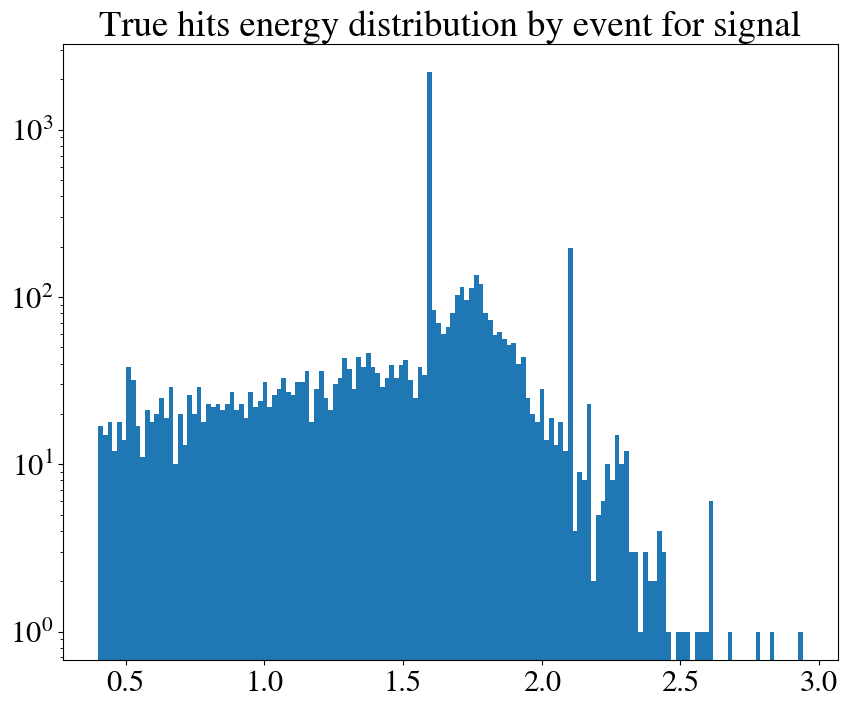

In [12]:
plt.hist(soph_true_data.groupby('event_id').energy.sum(), bins = 150)
plt.yscale('log')
plt.title('True hits energy distribution by event for signal')
plt.show()

### Collect the data signal events

In [ ]:
data = collect_signal_df(r'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/', r'/gluster/data/next/notebooks/john_books/soph_df_data/', verbose = False)


In [14]:
# collect the event numbers to make the sophronia file
pd.set_option('display.max_rows', 500)
display(data[data.creator_proc == 'conv'])

signal_ids = np.array(data.event_id.unique())
#np.save('soph_df_data/signal_ids.npy', signal_ids)


q = np.load('soph_df_data/signal_ids.npy', allow_pickle = True)
display(q)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
717,8,52,Xe132,False,49,315.167114,208.526917,731.868530,0.957737,315.166870,...,-0.571282,-0.011147,0.921331,-0.0,-0.0,0.0,4.784000e-06,0.000451,conv,NoProcess
718,8,51,e+,False,49,315.167114,208.526917,731.868530,0.957737,321.190308,...,0.535716,-0.354472,0.506607,0.0,0.0,-0.0,4.535802e-01,103.869461,conv,annihil
760,8,50,e-,False,49,315.167114,208.526917,731.868530,0.957737,262.783569,...,-0.717270,-1.333217,0.411308,0.0,-0.0,0.0,1.138922e+00,198.307587,conv,eIoni
2537,32,27,Xe132,False,24,194.737427,333.632263,357.662231,0.929959,194.737335,...,-0.187731,-0.408628,-0.038939,-0.0,-0.0,-0.0,8.292700e-07,0.000188,conv,NoProcess
2538,32,26,e+,False,24,194.737427,333.632263,357.662231,0.929959,185.969940,...,-0.614078,-0.068533,-0.558376,-0.0,-0.0,-0.0,4.660847e-01,50.315094,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21480,2900276,35,e+,False,33,143.392639,-394.430847,585.493896,2.769664,155.007217,...,-0.110865,-0.678076,0.542728,-0.0,-0.0,-0.0,5.027816e-01,120.939201,conv,annihil
21521,2900276,34,e-,False,33,143.392639,-394.430847,585.493896,2.769664,108.852020,...,0.034992,-1.340635,0.708975,-0.0,-0.0,0.0,1.089717e+00,125.825127,conv,eIoni
22862,2900290,47,Xe134,False,40,113.040726,100.920685,620.923828,1.400893,113.040482,...,-0.582610,-0.023961,0.207775,-0.0,-0.0,0.0,1.536348e-06,0.000257,conv,RadioactiveDecay
22863,2900290,46,e+,False,40,113.040726,100.920685,620.923828,1.400893,105.388817,...,-0.438755,-0.805850,0.040821,-0.0,0.0,0.0,5.400422e-01,105.159142,conv,annihil


array([8, 32, 33, ..., 2900275, 2900276, 2900290], dtype=object)

In [15]:
soph_data = collect_soph_signal_df(r'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/', q, save_path = r'/gluster/data/next/notebooks/john_books/soph_df_data/', MC_check = True)

100%|██████████| 300/300 [19:03<00:00,  3.81s/it]
/gluster/data/next/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block1_values] [items->Index(['event', 'npeak', 'nsipm', 'track_id'], dtype='object')]

  pytables.to_hdf(


In [13]:
display(soph_data.event.nunique())

6175

### Collect the true information from each of these events

In [31]:
soph_true_data = collect_signal_true_hits(r'/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/Q_THR4/PORT_1a/sophronia/', q, save_path = r'/gluster/data/next/notebooks/john_books/soph_df_data/')

100%|██████████| 300/300 [13:38<00:00,  2.73s/it]
/gluster/data/next/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['event_id', 'particle_id', 'hit_id', 'label'], dtype='object')]

  pytables.to_hdf(


### Now to process how many 1-tracks there are in both pre and post reco, and in truth

but first, beersheba nonsense:

In [ ]:
display(soph_data)
thresh = 4


In [ ]:
#hdst = soph_to_lowTh(soph_data, threshold = thresh)
hdst = soph_data
display(hdst)

In [ ]:
# take a subsample so this doesnt take forever to run
ev_ids = hdst.event.unique()
hdst = hdst[hdst.event < ev_ids[200]]
print("Number of events: {}".format(len(hdst.event.unique())))
display(hdst)

In [ ]:
thresh = 4
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
#file = f'../../../Tl_studies/LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_180_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = '/gluster/data/next/software/IC_satkill/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = thresh * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'/gluster/data/next/files/TOPOLOGY_John/LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = thresh,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 9e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 75,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  satellite_iter  = 25,                       # after how many iterations do you start scanning? 
                  satellite_dist  = 50,                        # how far away do two clouds have to be to be considered unique
                  satellite_size  = 5,                       # maximum size of satellites, beyond which they are considered signal.
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1.440, 1.440),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [ ]:
display(soph_true_data)
display(soph_data)

In [ ]:
if (datatype == 'MC'):
    #evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = soph_true_data
    true_info.event_id = (true_info.event_id*2).astype(int)
    
display(true_info)

In [ ]:
fast_run = True

event_ids = []


r_lim = 415
z_upper = 1170
z_lower = 20


cap = len(hdst.event.unique())


file_number = 999999 # alter this
q = 0

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 25

# true track number
true_trk_number = []
time_spent = []
track_number = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "signal_plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations'):
        os.makedirs(dir_name + '/iterations', exist_ok = True)
    

    
    
    
    # check first that the MCof this event is within the 
    this_evt_true_info = true_info[true_info.event_id == evt]

    xtMC = this_evt_true_info.x
    ytMC = this_evt_true_info.y
    ztMC = this_evt_true_info.z
    etMC = this_evt_true_info.energy*1000
    
    # Z
    z_max = ztMC.max()
    z_min = ztMC.min()
    
    # Radius
    r = np.sqrt(xtMC**2 + ytMC**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        print("MC Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        hits = hdst[hdst.event == evt]



        x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)



        hits_cut = coref.timefunc(cut_sensors)(hits.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

        # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
        if 'save_state' in locals():
            deconv_params_['n_iterations'] = save_state
        else:
            # first time round, so set it
            save_state = deconv_params_['n_iterations']

        iter_E = []
        iter_no = []
        i = 0
        p = 0


        deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)

        t0 = time.time()

        hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())




        # Z
        z_max = hits_deco.Z.max()
        z_min = hits_deco.Z.min()

        # Radius
        r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
        r_max = r.max()

        if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):

            print("RECO Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
        else:



            time_spent.append(time.time() - t0)


            # plot the MC

                   # load in MC
            #evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
            #true_info = mcio.load_mchits_df(soph_file).reset_index()
            #true_info.event_id = true_info.event_id.map(evtmap.evt_number)


            #this_evt_true_info = true_info[true_info.event_id == evt]

            #xtMC = this_evt_true_info.x
            #ytMC = this_evt_true_info.y
            #ztMC = this_evt_true_info.z
            #etMC = this_evt_true_info.energy*1000

            # collect true track number here
            true_trk_number.append(count_tracks_mc(this_evt_true_info))
            
            if (fast_run == False):
                fog = plt.figure()
                ax = fog.add_subplot(111, projection='3d')

                p = ax.scatter(xtMC, ytMC, ztMC, alpha = 0.1, color='red')
                cb = fog.colorbar(p, ax=ax)
                cb.set_label('Energy (keV)')


                ax.set_xlabel('x (mm)')
                ax.set_ylabel('y (mm)')
                ax.set_zlabel('z (mm)')
                fog.suptitle('True Hits_3D' + dir_name, fontsize=30)

                fog.savefig(dir_name + '/MC_3D.png')
                plt.close(fog)

            

                df_ps = data

                #for pid, df in this_evt_true_info.groupby('particle_id'):
                this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
                fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
                fug.suptitle('True Hits_' + dir_name, fontsize=30)
                #fig.tight_layout()
                added_labels = set()
                # Dictionary to store custom handles for the legend
                legend_handles = {}
                for pid, df in this_evt_true_info.groupby('particle_name'):

                    xt = df.x
                    yt = df.y
                    zt = df.z
                    et = df.energy*1000

                    axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
                    axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
                    axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


                    axus[0].set_xlabel('X (mm)');
                    axus[0].set_ylabel('Y (mm)');
                    axus[1].set_xlabel('X (mm)');
                    axus[1].set_ylabel('Z (mm)');
                    axus[2].set_xlabel('Y (mm)');
                    axus[2].set_ylabel('Z (mm)');

                # Retrieve legend handles and labels
                handles, labels = axus[0].get_legend_handles_labels()

                # Create a single legend for all subplots
                legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
                for handle in legend.legendHandles:
                    handle.set_alpha(1.0)

                fug.savefig(dir_name + '/MC_true.png')
                plt.close(fug)



            # if its within fiducial, keep it
            event_ids.append(evt)


            x = hits_deco.X
            y = hits_deco.Y
            z = hits_deco.Z
            e = hits_deco.E

            
            if (fast_run == False):
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                p = ax.scatter(x, y, z, c=e, alpha = 0.07, cmap='viridis')
                cb = fig.colorbar(p, ax=ax)
                cb.set_label('Energy (keV)')

                ax.scatter(xtMC, ytMC, ztMC, color='red')

                ax.set_xlabel('x (mm)')
                ax.set_ylabel('y (mm)')
                ax.set_zlabel('z (mm)')

                fig.suptitle('3D_deconvolved_' + str(int(evt)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
                #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
                fig.savefig(dir_name + '/iterations/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter_MCinc.png')
                plt.close(fig)

            # stick track number on after finishing
            track_number.append(count_tracks(hits_deco))



In [ ]:
file_no = str(deconv_params_['satellite_iter']) + 'i' + str(deconv_params_['satellite_dist']) + 'd' + str(deconv_params['satellite_size']) + 's' + str(len(hdst.event.unique())) + 'evts'

# save the output somewhere
np.save('signal_plots/time_spent_satkill' + str(file_no) + '.npy', np.array(time_spent))
np.save('signal_plots/track_num_satkill' + str(file_no) + '.npy', np.array(track_number))
np.save('signal_plots/true_trk_num' + str(file_no) + '.npy', np.array(true_trk_number))
np.save('signal_plots/eventids_satkill' + str(file_no) + '.npy', np.array(event_ids))

### No satellite killer

In [ ]:
event_ids = []


r_lim = 415
z_upper = 1170
z_lower = 20


cap = len(hdst.event.unique())


file_number = 999999 # alter this
q = 0

# this line applies the satellite killer
deconv_params_['satellite_iter'] = 99999

# true track number
true_trk_number = []
time_spent = []
track_number = []

for i in range(len(hdst.event.unique())):
    print("event {},{}/{}".format(hdst.event.unique()[i],q, cap))
    q += 1
    if (q == cap):
        break
        
    #evt = int(saved_signal_evts[i]*2)
    evt = hdst.event.unique()[i]
    # signal events is the lower half
    dir_name = "signal_plots/" + "event_" + str(hdst.event.unique()[i]) + "_file_" + str(file_number)
    if not os.path.exists(dir_name + '/iterations'):
        os.makedirs(dir_name + '/iterations', exist_ok = True)
    

    
    
    
    # check first that the MCof this event is within the 
    this_evt_true_info = true_info[true_info.event_id == evt]

    xtMC = this_evt_true_info.x
    ytMC = this_evt_true_info.y
    ztMC = this_evt_true_info.z
    etMC = this_evt_true_info.energy*1000
    
    # Z
    z_max = ztMC.max()
    z_min = ztMC.min()
    
    # Radius
    r = np.sqrt(xtMC**2 + ytMC**2)
    r_max = r.max()

    if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):
        print("MC Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
    else:
        hits = hdst[hdst.event == evt]



        x_range, y_range, z_range, mid_x, mid_y, mid_z, min_x, min_y, min_z, max_x, max_y, max_z, xbins, ybins, zbins = collect_min_max_bins(hits)



        hits_cut = coref.timefunc(cut_sensors)(hits.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

        # this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
        if 'save_state' in locals():
            deconv_params_['n_iterations'] = save_state
        else:
            # first time round, so set it
            save_state = deconv_params_['n_iterations']

        iter_E = []
        iter_no = []
        i = 0
        p = 0


        deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)

        t0 = time.time()

        hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())




        # Z
        z_max = hits_deco.Z.max()
        z_min = hits_deco.Z.min()

        # Radius
        r = np.sqrt(hits_deco.X**2 + hits_deco.Y**2)
        r_max = r.max()

        if ((z_max > z_upper) or (z_min < z_lower) or (r_max > r_lim)):

            print("RECO Max reached at: {}, {}, {}".format(z_max, z_min, r_max))
        else:



            time_spent.append(time.time() - t0)


                        # collect true track number here
            true_trk_number.append(count_tracks_mc(this_evt_true_info))
            # plot the MC

                   # load in MC
            #evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
            #true_info = mcio.load_mchits_df(soph_file).reset_index()
            #true_info.event_id = true_info.event_id.map(evtmap.evt_number)


            #this_evt_true_info = true_info[true_info.event_id == evt]

            #xtMC = this_evt_true_info.x
            #ytMC = this_evt_true_info.y
            #ztMC = this_evt_true_info.z
            #etMC = this_evt_true_info.energy*1000

            if (fast_run == False):
                fog = plt.figure()
                ax = fog.add_subplot(111, projection='3d')

                p = ax.scatter(xtMC, ytMC, ztMC, alpha = 0.1, color='red')
                cb = fog.colorbar(p, ax=ax)
                cb.set_label('Energy (keV)')


                ax.set_xlabel('x (mm)')
                ax.set_ylabel('y (mm)')
                ax.set_zlabel('z (mm)')
                fog.suptitle('True Hits_3D' + dir_name, fontsize=30)

                fog.savefig(dir_name + '/MC_3D.png')
                plt.close(fog)




                df_ps = data

                #for pid, df in this_evt_true_info.groupby('particle_id'):
                this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)
                fug, axus = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
                fug.suptitle('True Hits_' + dir_name, fontsize=30)
                #fig.tight_layout()
                added_labels = set()
                # Dictionary to store custom handles for the legend
                legend_handles = {}
                for pid, df in this_evt_true_info.groupby('particle_name'):

                    xt = df.x
                    yt = df.y
                    zt = df.z
                    et = df.energy*1000

                    axus[0].scatter(xt, yt,  alpha=0.1, label = str(pid))
                    axus[1].scatter(xt, zt,  alpha=0.1, label = str(pid))
                    axus[2].scatter(yt, zt,  alpha=0.1, label = str(pid))


                    axus[0].set_xlabel('X (mm)');
                    axus[0].set_ylabel('Y (mm)');
                    axus[1].set_xlabel('X (mm)');
                    axus[1].set_ylabel('Z (mm)');
                    axus[2].set_xlabel('Y (mm)');
                    axus[2].set_ylabel('Z (mm)');

                # Retrieve legend handles and labels
                handles, labels = axus[0].get_legend_handles_labels()

                # Create a single legend for all subplots
                legend = fug.legend(handles, labels, fontsize=15, loc = 'lower left')
                for handle in legend.legendHandles:
                    handle.set_alpha(1.0)

                fug.savefig(dir_name + '/MC_true.png')
                plt.close(fug)



            # if its within fiducial, keep it
            event_ids.append(evt)


            x = hits_deco.X
            y = hits_deco.Y
            z = hits_deco.Z
            e = hits_deco.E

            if (fast_run == False):
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                p = ax.scatter(x, y, z, c=e, alpha = 0.07, cmap='viridis')
                cb = fig.colorbar(p, ax=ax)
                cb.set_label('Energy (keV)')

                ax.scatter(xtMC, ytMC, ztMC, color='red')

                ax.set_xlabel('x (mm)')
                ax.set_ylabel('y (mm)')
                ax.set_zlabel('z (mm)')

                fig.suptitle('3D_deconvolved_' + str(int(evt)) + "_iteration " + str(deconv_params_['n_iterations']), fontsize=30)
                #fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")
                fig.savefig(dir_name + '/iterations/3D_plot_' + str(deconv_params_['n_iterations']) + '_iter_MCinc_nosat.png')
                plt.close(fig)

            # stick track number on after finishing
            track_number.append(count_tracks(hits_deco))



In [ ]:
# save the output somewhere
np.save('signal_plots/time_spent_no_satkill_comparison.npy', np.array(time_spent))
np.save('signal_plots/track_num_no_satkill_comparison.npy', np.array(track_number))
np.save('signal_plots/true_trk_no_satkill_num_comparison.npy', np.array(true_trk_number))
np.save('signal_plots/eventids_no_satkill_comparison.npy', np.array(event_ids))

In [ ]:
# compare them here quickly

